# Load basic config

In [ ]:
import qubecalib as qc
import qubecalib.ui as ui
from qubecalib import UpConverter, LocalOscillator
from qubecalib.ui import Qube
import e7awgsw
import subprocess

QUBE = Qube()
display(ui.LoadConfigPanel(QUBE))
QUBE.qube.load('qube_riken_1-10.yml') # <- TODO: ここ訂正
# ハードウェアのコンフィグが終わっていれば，Load した時点で Qube オブジェクトから QuBE を操れる

In [ ]:
QUBE.config

In [ ]:
subprocess.run(["ping",QUBE.config['iplsi'],"-c","2", "-W", "300"],stdout=subprocess.PIPE).stdout

# Config FPGA

In [ ]:
QUBE.do_init(rf_type='A', bitfile='/home/qube/bin/{}'.format(QUBE.config['bitfile']), message_out=False); print('done')

In [ ]:
subprocess.run(["ping",QUBE.config['ipfpga'],"-c","2", "-W", "300"],stdout=subprocess.PIPE).stdout

# Initialize LSIs

In [ ]:
QUBE.do_init(message_out=False); print('done')

# Restart ADC/DAC

In [ ]:
QUBE.restart_ad9082(message_out=False); print('done')

# Check ADC/DAC status

In [ ]:
print(QUBE.qube.ad9082[0].get_jesd_status())
print(QUBE.qube.ad9082[1].get_jesd_status())
print(QUBE.config['iplsi'])
print(QUBE.config['ipfpga'])
print(QUBE.config['bitfile'])

# Support Functions

In [ ]:
import numpy as np

def set_sideband_config(adrf6780, qube_type = 'A'):
    o = adrf6780
    if qube_type == 'A':
        o[0].set_usb()
        o[1].set_usb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_usb()
        o[7].set_usb()
    else:
        o[0].set_lsb()
        o[1].set_lsb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_lsb()
        o[7].set_lsb()

def set_lo(port, mhz, apply=True):
    qc.set_lmx2594_freq_100M(port.local.lsi, int(mhz*1e-2))
    if apply:
        qc.apply_lmx2594(port.local.lsi)

def set_nco(port, mhz):
    ifdac = port.dac
    ifdac.lsi.set_nco(freq=mhz*1e+6, ch=ifdac.ch)

def set_nco_ifadc(port, mhz, ch):
    ifdac = port.dac
    ifdac.lsi.set_nco(freq=mhz*1e+6, ch=ch, adc_mode=True)
    
def set_lo_nco(port, lo, nco):
    set_lo(port, lo)
    set_nco(port, nco)

def gen_ctrl_wave_samples(params):
    num_cycles = params.ctrl_freq * params.ctrl_wave_len * 1e-3
    return sr.gen_cos_wave(params.ctrl_freq, num_cycles, 32767, e7awgsw.AwgCtrl.SAMPLING_RATE)


def set_wave_sequence(awg_ctrl, params):
    # サンプル作成
    ctrl_i_samples, ctrl_q_samples = gen_ctrl_wave_samples(params)
    ro_i_samples, ro_q_samples = sr.gen_readout_wave_samples(params, len(ctrl_i_samples))

    # 波形シーケンス作成
    ro_wave_seq = sr.gen_readout_wave_seq(params, ro_i_samples, ro_q_samples)
    ctrl_wave_seq = sr.gen_ctrl_wave_seq(
        params, ro_wave_seq.chunk(0).num_samples, ctrl_i_samples, ctrl_q_samples)

    # control 波形と readout 波形の長さが一致することを確認
    assert ctrl_wave_seq.num_all_words == ro_wave_seq.num_all_words

    awg_ctrl.set_wave_sequence(AWG_LIST.ctrl_awg_0, ctrl_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.ctrl_awg_1, ctrl_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.readout_awg_0, ro_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.readout_awg_1, ro_wave_seq)
    return {
        AWG_LIST.ctrl_awg_0 : ctrl_wave_seq,
        AWG_LIST.ctrl_awg_1 : ctrl_wave_seq,
        AWG_LIST.readout_awg_0 : ro_wave_seq,
        AWG_LIST.readout_awg_1 : ro_wave_seq
    }
    
def sendrecv(wave_params, capture_modules, use_labrad, server_ip_addr):
    with (sr.create_awg_ctrl(use_labrad, server_ip_addr) as awg_ctrl,
          sr.create_capture_ctrl(use_labrad, server_ip_addr) as cap_ctrl):
        capture_units = CaptureModule.get_units(*capture_modules)
        # 初期化
        awg_ctrl.initialize(*AWG_LIST)
        cap_ctrl.initialize(*capture_units)
        # トリガ AWG の設定
        sr.set_trigger_awg(cap_ctrl, AWG_LIST.ctrl_awg_0, capture_modules)
        # 波形シーケンスの設定
        awg_to_wave_sequence = set_wave_sequence(awg_ctrl, wave_params)
        # キャプチャパラメータの設定
        sr.set_capture_params(
            cap_ctrl,
            awg_to_wave_sequence[AWG_LIST.ctrl_awg_0],
            awg_to_wave_sequence[AWG_LIST.readout_awg_0],
            capture_units)
        # 波形送信スタート
        awg_ctrl.start_awgs(*AWG_LIST)
        # 波形送信完了待ち
        awg_ctrl.wait_for_awgs_to_stop(5, *AWG_LIST)
        # キャプチャ完了待ち
        cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
        # エラーチェック
        sr.check_err(awg_ctrl, cap_ctrl, AWG_LIST, capture_units)
        # キャプチャデータ取得
        capture_unit_to_capture_data = sr.get_capture_data(cap_ctrl, capture_units)
    return capture_unit_to_capture_data

def sendrecv2(wave_params, capture_modules, use_labrad, server_ip_addr):
    with (sr.create_awg_ctrl(use_labrad, server_ip_addr) as awg_ctrl,
          sr.create_capture_ctrl(use_labrad, server_ip_addr) as cap_ctrl):
        capture_units = CaptureModule.get_units(*capture_modules)
        # 初期化
        awg_ctrl.initialize(*AWG_LIST)
        cap_ctrl.initialize(*capture_units)
        # トリガ AWG の設定
        sr.set_trigger_awg(cap_ctrl, AWG_LIST.ctrl_awg_0, capture_modules)
        # 波形シーケンスの設定
        awg_to_wave_sequence = sr.set_wave_sequence(awg_ctrl, wave_params)
        # キャプチャパラメータの設定
        sr.set_capture_params(
            cap_ctrl,
            awg_to_wave_sequence[AWG_LIST.ctrl_awg_0],
            awg_to_wave_sequence[AWG_LIST.readout_awg_0],
            capture_units)
        # 波形送信スタート
        awg_ctrl.start_awgs(*AWG_LIST)
        # 波形送信完了待ち
        awg_ctrl.wait_for_awgs_to_stop(5, *AWG_LIST)
        # キャプチャ完了待ち
        cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
        # エラーチェック
        sr.check_err(awg_ctrl, cap_ctrl, AWG_LIST, capture_units)
        # キャプチャデータ取得
        print('cap',)
        capture_unit_to_capture_data = sr.get_capture_data(cap_ctrl, capture_units)
        print(list(capture_unit_to_capture_data))
        print('awg',)
        awg_to_wave_data = {awg: wave_seq.all_samples(False) for awg, wave_seq in awg_to_wave_sequence.items()}
        print(list(awg_to_wave_data))
        print('done')
    return capture_unit_to_capture_data, awg_to_wave_data


def myplot(axs, data):
    SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
    o = [np.array(v) for k, v in data.items()]
    time = np.linspace(0, 1e+6 * o[-1].shape[0] / SAMPLING_RATE, o[-1].shape[0], endpoint=False)
    for i, v in enumerate(o[::4]):
        axs[i,0].plot(time, v[:,0])
        axs[i,1].plot(time, v[:,1])
        
def set_vatt(vatt, v, apply=True): # max 4095
    vatt.lsi.write_value(vatt.ch, v)
    if apply:
        apply_vatt(vatt.lsi)

def apply_vatt(ad5328):
    ad5328.write_value(0xA, 0x002)
    return True


# RF部周波数の設定

In [ ]:
TARGET = 10109.5 # <- フィルタ特性より 9609.5 から変更
LO = 9000 # 500M
NCO = 1093.75 # (111//15.625)*15.625
FAWG0 = TARGET - LO - NCO
# TARGET = LO + (IF + FAWG0)

fmt = lambda k, v: '{:>2.0f}: {}'.format(k,v.get_status())
p = QUBE.qube.ports[0]
p.set_lo(LO)
p.set_if(NCO) # <- TODO: 要修正
print(fmt(0,p))
print(fmt(1,QUBE.qube.ports[1]))
#set_vatt(p.upconv.vatt, 0x700) # Max -45.93 dBm
# set_vatt(p.upconv.vatt, 0x600) # -49 dBm
set_vatt(p.upconv.vatt, 0xA00) # -49 dBm
# RF = 9611 MHz = 8100 + 1400 + 111

TARGET, LO, NCO = 10109.5, 11000, 906.25
FAWG0 = TARGET + NCO - LO

fmt = lambda k, v: '{:>2.0f}: {}'.format(k,v.get_status())
p = QUBE.qube.ports[5]
p.set_lo(LO)
p.set_if(NCO) # <- TODO: 要修正
print(fmt(5,p))
set_vatt(p.upconv.vatt, 0xA00) # -49 dBm


# 波形も 64 サンプルの倍数で作成する

QUBE.qube.ad9082[0].set_nco(freq=NCO*1e+6, ch=3, adc_mode=True)
QUBE.qube.ad9082[1].set_nco(freq=NCO*1e+6, ch=3, adc_mode=True)

pass

# LongSend の試験

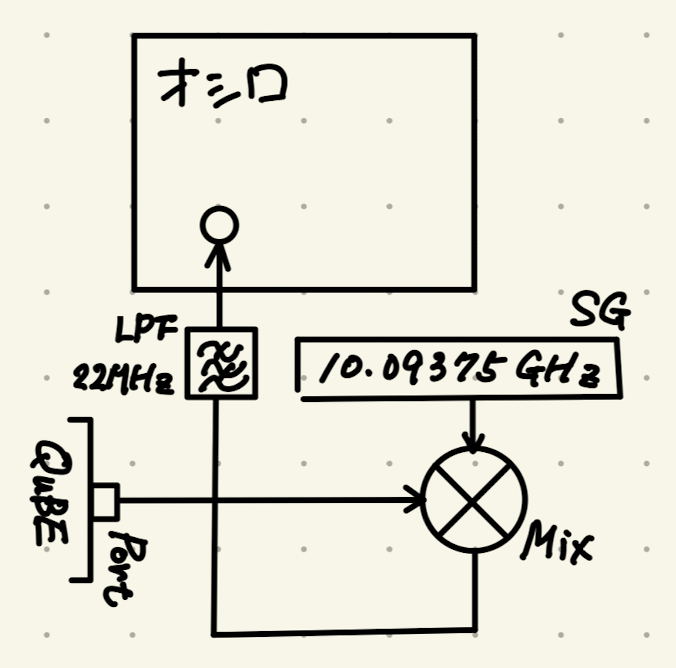

In [ ]:
set_vatt(QUBE.qube.ports[0].upconv.vatt,0x600)

In [ ]:
qc.LongSend.start(QUBE.qube.ports[0])

In [ ]:
qc.LongSend.stop(QUBE.qube.ports[0])

In [ ]:
import e7awg_sw.examples.send_recv_dsp.send_recv_integ as sr
from e7awg_sw.examples.send_recv_dsp.send_recv_integ import AWG, CaptureModule
from collections import namedtuple
import pickle
import numpy as np

qube = QUBE.qube
port = qube.ports

sr.IP_ADDR = QUBE.config['ipfpga']
AWG_LIST = sr.awg_list(
    ctrl_awg_0 = AWG.U0,
    ctrl_awg_1 = AWG.U13,
    readout_awg_0 = AWG.U2,
    readout_awg_1 = AWG.U15
)
sr.AWG_LIST = AWG_LIST

ctrl_wave_len = 100
capture_modules = sr.CaptureModule.all()
server_ip_addr = 'localhost'

p = QUBE.qube.ports[5]
p.set_lo(10900)
p.set_if(2700)
p.get_status()
set_vatt(p.upconv.vatt, 0x400)

sr.ADDITIONAL_CAPTURE_DELAY = 0

TARGET = 9611
LO = 8500 # 500M
IF = 1093.75 # (111//15.625)*15.625
FAWG0 = TARGET - LO - IF

p = QUBE.qube.ports[0] # Resonant Frequency 9611 MHz
p.set_lo(LO)
p.set_if(IF)
p.get_status()
#set_vatt(p.upconv.vatt, 0x700) # Max -45.93 dBm
set_vatt(p.upconv.vatt, 0x600) # -49 dBm
# RF = 9611 MHz = 8100 + 1400 + 111

# 波形も 64 サンプルの倍数で作成する

QUBE.qube.ad9082[0].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
QUBE.qube.ad9082[1].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)


#IF = TARGET - LO - FAWG0

#FAWG0 = 9711 - LO - IF


#Fawg = 151 # MHz

rslt = []
iq_mean = []
for Fawg in FAWG0 + 10*np.linspace(-1,1,21):
# 0.1374435494319231for Fawg in 111 + np.ones(11):
    print(LO + IF + Fawg)
    wparams = sr.wave_params(
        num_wait_words = 0,
        ctrl_freq = 100, # MHz
        ctrl_wave_len = ctrl_wave_len, # ns
        readout_freq = Fawg, # MHz,
        readout_wave_len = 1000, # ns,
        readout_blank_len = 0.1, # ms
        # num_chunk_repeats = 10000, # 積算回数
        num_chunk_repeats = 10000# 積算回数
    )
    
    # _ = [print(k, v.get_status()) for k, v in QUBE.qube.ports.items()]
    
    family_no, personal_id = QUBE.config_file_name.split('_')[2].split('.')[0].split('-')
    fname = 'Qube{}_{}_readin.pickle'.format(family_no, personal_id)
    #[set_nco_ifadc(port[0], 1400, i) for i in range(4)] # とりあえず全チャンネルを設定 ADC IF 設定
    QUBE.qube.ad9082[0].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
    QUBE.qube.ad9082[1].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
    d = sendrecv(wparams, capture_modules, False, server_ip_addr)
    rslt.append(d)
    
    %matplotlib inline
    import numpy as np
    import matplotlib.pylab as plt

    f, axs = plt.subplots(1,1, figsize=(18,4))
    SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
    o = [np.array(v) for k, v in d.items()]
    time = np.linspace(0, 1e+6 * o[-1].shape[0] / SAMPLING_RATE, o[-1].shape[0], endpoint=False)
    local = np.exp(-1j*(2*np.pi*Fawg*time))
    i, v = 0, o[4]
    w = v[:,0] + 1j * v[:,1]
    x = w# * local
    #iq_mean.append(np.mean(x))
    #axs[i,0].plot(time, np.abs(x))#np.real(x))
    axs.plot(time, np.real(x))
    # axs[i,1].plot(time, np.unwrap(np.angle(x)))
    #axs[i,0].set_ylim(0,2e+5)
    plt.show()

# 周波数設定

In [ ]:
set_sideband_config(QUBE.qube.adrf6780, qube_type = 'A')

In [ ]:
['{:>2.0f}: {}'.format(k, v.get_status()) for k,v in QUBE.qube.ports.items()]# TODO: Port 6が変

In [ ]:
QUBE.qube.adrf6780[3],QUBE.qube.ports[6].upconv.lsi

In [ ]:
QUBE.qube.ports[6].upconv.lsi.read_mode()#set_lsb()

In [ ]:
QUBE.qube.adrf6780[3].set_lsb()

# Readout からのパルス出力
SG: MG3692A, 10093.750 MHz, +7dBm

In [ ]:
TARGET, LO, NCO = 10109.5, 9000, 1093.75
FAWG0 = TARGET - LO - NCO

fmt = lambda k, v: '{:>2.0f}: {}'.format(k,v.get_status())
p = QUBE.qube.ports[0]
p.set_lo(LO)
p.set_if(NCO) # <- TODO: 要修正
print(fmt(0,p))
set_vatt(p.upconv.vatt, 0xA00) # -49 dBm
pass

In [ ]:
import math
import numpy as np
from e7awgsw import AWG, AwgCtrl, WaveSequence, SinWave, IqWave


def gen_wave_samples(duration, freq, amp=32767): # duration [s], freq [Hz]
    num_cycles = duration * freq
    i_samples = SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp, phase = math.pi / 2).gen_samples(AwgCtrl.SAMPLING_RATE)
    q_samples = SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp).gen_samples(AwgCtrl.SAMPLING_RATE)
    return (i_samples, q_samples)


def gen_wave_seq(duration, freq, amp=32767): # duration [s], freq [Hz]
    wave_seq = WaveSequence(
        num_wait_words = 0,
        num_repeats = 1)
    
    i_samples, q_samples = gen_wave_samples(duration, freq, amp)
    iq_samples = IqWave.convert_to_iq_format(i_samples, q_samples, padding_size = WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK)
    
    wave_seq.add_chunk(
        iq_samples = iq_samples,
        num_blank_words = 0, 
        num_repeats = 1)
    return wave_seq


awgs = [AWG.U15,] # Port 0
awg_ctrl = AwgCtrl('10.1.0.28')
awg_ctrl.initialize(*awgs)
wave_seq = gen_wave_seq(2000e-9, 10.5e+6)
for awg in awgs:
    awg_ctrl.set_wave_sequence(awg, wave_seq)
awg_ctrl.start_awgs(*awgs)

# Ctrl(P5) からのパルス出力

In [ ]:
TARGET, LO, NCO = 10109.5, 11000, 906.25
FAWG0 = TARGET + NCO - LO

fmt = lambda k, v: '{:>2.0f}: {}'.format(k,v.get_status())
p = QUBE.qube.ports[5]
p.set_lo(LO)
p.set_if(NCO) # <- TODO: 要修正
print(fmt(0,p), FAWG0)
set_vatt(p.upconv.vatt, 0xA00) # -49 dBm
pass

In [ ]:
fmagic = 15.625 # MHz
int(1101//fmagic), (1101//fmagic)*fmagic, int(920//fmagic), (920//fmagic)*fmagic

In [ ]:
import math
import numpy as np
from e7awgsw import AWG, AwgCtrl, WaveSequence, SinWave, IqWave

awgs = [AWG.U11,AWG.U12,AWG.U13,] # Port 0
awg_ctrl = AwgCtrl('10.1.0.28')
awg_ctrl.initialize(*awgs)
wave_seq = gen_wave_seq(1000e-9, 10.5e+6)
for awg in awgs:
    awg_ctrl.set_wave_sequence(awg, wave_seq)
awg_ctrl.start_awgs(*awgs)

# Readout(P0) と Readin(P1) の LongSend と Recv との組み合わせでの観測

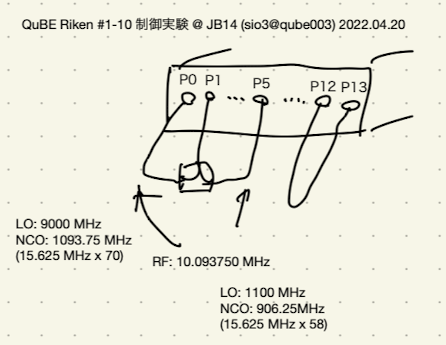

In [ ]:
# 正弦的連続波の発生
QUBE.qube.ports[1].adc.set_fnco(1093.75) # MHz
set_vatt(QUBE.qube.ports[0].upconv.vatt,0x600)
qc.LongSend.start(QUBE.qube.ports[0])
['{:>2.0f}: {}'.format(k, v.get_status()) for k,v in QUBE.qube.ports.items()]

In [ ]:
from e7awgsw import CaptureCtrl, CaptureModule, CaptureParam

num_capture_words = 1024
capture_delay = 100

def gen_capture_param(num_capture_words):
    capture_param = CaptureParam()
    capture_param.num_integ_sections = 1
    capture_param.add_sum_section(num_capture_words, 1) # 総和区間を 1 つだけ定義する
    capture_param.capture_delay = capture_delay
    return capture_param

def set_capture_params(cap_ctrl, num_capture_words, capture_units):
    capture_param = gen_capture_param(num_capture_words)
    for captu_unit_id in capture_units:
        cap_ctrl.set_capture_params(captu_unit_id, capture_param)

def get_capture_data(cap_ctrl, capture_units):
    unit2data = {}
    for capture_unit_id in capture_units:
        num_captured_samples = cap_ctrl.num_captured_samples(capture_unit_id)
        unit2data[capture_unit_id] = (
            cap_ctrl.get_capture_data(capture_unit_id, num_captured_samples))
    return unit2data

capture_modules = QUBE.qube.ports[1].adc.caps
capture_units = CaptureModule.get_units(*capture_modules)

cap_ctrl = CaptureCtrl(QUBE.config['ipfpga'])
cap_ctrl.initialize(*capture_units)
set_capture_params(cap_ctrl, num_capture_words, capture_units)
cap_ctrl.start_capture_units(*capture_units)
cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
d = get_capture_data(cap_ctrl, capture_units)

%matplotlib inline
import matplotlib.pyplot as plt

a = np.array(d[4])
time = np.linspace(0, 1e+6 * a.shape[0] / CaptureCtrl.SAMPLING_RATE, a.shape[0], endpoint=False)
plt.plot(time, a[:,0])
plt.plot(time, a[:,1])

In [ ]:
qc.LongSend.stop(QUBE.qube.ports[0])
['{:>2.0f}: {}'.format(k, v.get_status()) for k,v in QUBE.qube.ports.items()]

# Ctrl(P5) と Readin(P1) の LongSend と Recv との組み合わせでの観測

In [ ]:
['{:>2.0f}: {}'.format(k, v.get_status()) for k,v in QUBE.qube.ports.items()]

In [ ]:
# 正弦的連続波の発生
QUBE.qube.ports[1].adc.set_fnco(1093.75) # MHz

TARGET, LO, NCO = 10109.5, 11000, 906.25
FAWG0 = TARGET + NCO - LO

fmt = lambda k, v: '{:>2.0f}: {}'.format(k,v.get_status())
p = QUBE.qube.ports[5]
p.set_lo(LO)
p.set_if(NCO) # <- TODO: 要修正
set_vatt(p.upconv.vatt, 0x600)

print(FAWG0)
qc.LongSend.start(p)

In [ ]:
num_capture_words = 1024
capture_delay = 100

capture_modules = QUBE.qube.ports[1].adc.caps
capture_units = CaptureModule.get_units(*capture_modules)

cap_ctrl = CaptureCtrl(QUBE.config['ipfpga'])
cap_ctrl.initialize(*capture_units)
set_capture_params(cap_ctrl, num_capture_words, capture_units)
cap_ctrl.start_capture_units(*capture_units)
cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
d = get_capture_data(cap_ctrl, capture_units)

%matplotlib inline
import matplotlib.pyplot as plt

a = np.array(d[4])
time = np.linspace(0, 1e+6 * a.shape[0] / CaptureCtrl.SAMPLING_RATE, a.shape[0], endpoint=False)
plt.plot(time, a[:,0])
plt.plot(time, a[:,1])

In [ ]:
qc.LongSend.stop(QUBE.qube.ports[5])

In [ ]:
1/64 # [1/ns] 15.625 [kHz]

# Readout(P0) と Ctrl(P5) からのパルス出力を Readin(P1) で観測

In [ ]:
from collections import namedtuple
from e7awgsw import AWG, AwgCtrl, CaptureCtrl, CaptureModule, CaptureParam, DspUnit


ADDITIONAL_CAPTURE_DELAY = 0 # cpature words = cycyles@125MHz 


wave_params = namedtuple(
    'WaveParams',
    ('num_wait_words',
     'ctrl_freq',
     'ctrl_wave_len',
     'readout_freq',
     'readout_wave_len',
     'readout_blank_len',
     'num_chunk_repeats'))


awg_list = namedtuple(
    'AwgList',
    ('ctrl_awg_0',
     'ctrl_awg_1',
     'readout_awg_0',
     'readout_awg_1'))


AWG_LIST = awg_list(
    ctrl_awg_0 = AWG.U11,
    ctrl_awg_1 = AWG.U0,
    readout_awg_0 = AWG.U15,
    readout_awg_1 = AWG.U2
)

def set_trigger_awg(cap_ctrl, awg, capture_modules):
    for cap_mod_id in capture_modules:
        cap_ctrl.select_trigger_awg(cap_mod_id, awg)
        cap_ctrl.enable_start_trigger(*CaptureModule.get_units(cap_mod_id))


def gen_cos_wave(freq, num_cycles, amp, sampling_rate):
    freq = freq * 1e6
    i_samples = SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp, phase = math.pi / 2).gen_samples(sampling_rate)
    q_samples = SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp).gen_samples(sampling_rate)
    return (i_samples, q_samples)


def gen_ctrl_wave_seq(params, num_all_samples, i_samples, q_samples):
    iq_samples = IqWave.convert_to_iq_format(i_samples, q_samples, WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK)
    num_blank_samples = num_all_samples - len(iq_samples)
    num_blank_words = num_blank_samples // WaveSequence.NUM_SAMPLES_IN_AWG_WORD

    wave_seq = WaveSequence(num_wait_words = params.num_wait_words, num_repeats = 1)
    wave_seq.add_chunk(
        iq_samples = iq_samples,
        num_blank_words = num_blank_words, 
        num_repeats = params.num_chunk_repeats
    )
    return wave_seq


def gen_readout_wave_samples(params, num_pre_blank_samples):
    num_cycles = params.readout_freq * params.readout_wave_len * 1e-3
    i_samples, q_samples = gen_cos_wave(params.readout_freq, num_cycles, 32760, AwgCtrl.SAMPLING_RATE)
    i_samples = [0] * num_pre_blank_samples + i_samples
    q_samples = [0] * num_pre_blank_samples + q_samples
    return (i_samples, q_samples)


def gen_readout_wave_seq(params, i_samples, q_samples):
    iq_samples = IqWave.convert_to_iq_format(i_samples, q_samples, WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK)
    # I/Q サンプルに付加された 0 データの分 readout 波形のブランクを短くする
    num_added_samples = len(iq_samples) - len(i_samples)
    num_blank_samples = max(
        int(AwgCtrl.SAMPLING_RATE * params.readout_blank_len / 1e3) - num_added_samples, 0)
    num_blank_words = num_blank_samples // WaveSequence.NUM_SAMPLES_IN_AWG_WORD

    wave_seq = WaveSequence(num_wait_words = params.num_wait_words, num_repeats = 1)
    wave_seq.add_chunk(
        iq_samples = iq_samples,
        num_blank_words = num_blank_words, 
        num_repeats = params.num_chunk_repeats
    )
    return wave_seq


def set_wave_sequence(awg_ctrl, params):
    
    def gen_ctrl_wave_samples():
        num_cycles = params.ctrl_freq * params.ctrl_wave_len * 1e-3
        return gen_cos_wave(params.ctrl_freq, num_cycles, 32760, AwgCtrl.SAMPLING_RATE)

    ctrl_i_samples, ctrl_q_samples = gen_ctrl_wave_samples() # サンプル作成
    ro_i_samples, ro_q_samples = gen_readout_wave_samples(params, len(ctrl_i_samples)) # サンプル作成

    
    ro_wave_seq = gen_readout_wave_seq(params, ro_i_samples, ro_q_samples) # 波形シーケンス作成
    ctrl_wave_seq = gen_ctrl_wave_seq(
        params, ro_wave_seq.chunk(0).num_samples, ctrl_i_samples, ctrl_q_samples)

    # control 波形と readout 波形の長さが一致することを確認
    assert ctrl_wave_seq.num_all_words == ro_wave_seq.num_all_words

    awg_ctrl.set_wave_sequence(AWG_LIST.ctrl_awg_0, ctrl_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.ctrl_awg_1, ctrl_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.readout_awg_0, ro_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.readout_awg_1, ro_wave_seq)
    return {
        AWG_LIST.ctrl_awg_0 : ctrl_wave_seq,
        AWG_LIST.ctrl_awg_1 : ctrl_wave_seq,
        AWG_LIST.readout_awg_0 : ro_wave_seq,
        AWG_LIST.readout_awg_1 : ro_wave_seq
    }


def set_capture_params(cap_ctrl, ctrl_wave_seq, ro_wave_seq, capture_units):
    capture_param = gen_capture_param(ctrl_wave_seq, ro_wave_seq)
    for captu_unit_id in capture_units:
        cap_ctrl.set_capture_params(captu_unit_id, capture_param)


def gen_capture_param(ctrl_wave_seq, ro_wave_seq):
    capture_param = CaptureParam()
    capture_param.num_integ_sections = ro_wave_seq.chunk(0).num_repeats # 積算区間数

    # readout 波形の長さから, 追加で 1us キャプチャするためのキャプチャワード数を計算
    additional_capture_words = int(1e-6 * CaptureCtrl.SAMPLING_RATE) // CaptureParam.NUM_SAMPLES_IN_ADC_WORD
    additional_capture_words = min(additional_capture_words, ro_wave_seq.chunk(0).num_blank_words - 1)

    sum_section_len = ro_wave_seq.chunk(0).num_words - ro_wave_seq.chunk(0).num_blank_words + additional_capture_words
    num_blank_words = ro_wave_seq.chunk(0).num_words - sum_section_len
    capture_param.add_sum_section(sum_section_len, num_blank_words)
    capture_param.sum_start_word_no = 0
    capture_param.num_words_to_sum = CaptureParam.MAX_SUM_SECTION_LEN
    capture_param.sel_dsp_units_to_enable(DspUnit.INTEGRATION)
    capture_param.capture_delay = ctrl_wave_seq.num_wait_words + ctrl_wave_seq.chunk(0).num_wave_words
    capture_param.capture_delay += ADDITIONAL_CAPTURE_DELAY
    # readout 波形のサンプル数とキャプチャするサンプル数が一致することを確認
    assert ro_wave_seq.num_all_samples == capture_param.num_samples_to_process
    return capture_param


def get_capture_data(cap_ctrl, capture_units):
    capture_unit_to_capture_data = {}
    for capture_unit_id in capture_units:
        num_captured_samples = cap_ctrl.num_captured_samples(capture_unit_id)
        capture_unit_to_capture_data[capture_unit_id] = cap_ctrl.get_capture_data(capture_unit_id, num_captured_samples)
    return capture_unit_to_capture_data


def check_err(awg_ctrl, cap_ctrl, awgs, capture_units):
    awg_to_err = awg_ctrl.check_err(*awgs)
    for awg_id, err_list in awg_to_err.items():
        print(awg_id)
        for err in err_list:
            print('    {}'.format(err))
    
    cap_unit_to_err = cap_ctrl.check_err(*capture_units)
    for cap_unit_id, err_list in cap_unit_to_err.items():
        print('{} err'.format(cap_unit_id))
        for err in err_list:
            print('    {}'.format(err))

            
ctrl_wave_len = 100

wparams = wave_params(
    num_wait_words = 0,
    ctrl_freq = 20, # MHz
    ctrl_wave_len = ctrl_wave_len, # ns
    readout_freq = 10, # MHz,
    readout_wave_len = 2000, # ns,
    readout_blank_len = 0.1, # ms
    num_chunk_repeats = 100, # 積算回数
)

capture_modules = QUBE.qube.ports[1].adc.caps + QUBE.qube.ports[12].adc.caps
capture_units = CaptureModule.get_units(*capture_modules)

cap_ctrl = CaptureCtrl(QUBE.config['ipfpga'])
awg_ctrl = AwgCtrl(QUBE.config['ipfpga'])

# 初期化
awg_ctrl.initialize(*AWG_LIST)
cap_ctrl.initialize(*capture_units)

# トリガ AWG の設定
set_trigger_awg(cap_ctrl, AWG_LIST.ctrl_awg_0, capture_modules)

# 波形シーケンスの設定
awg_to_wave_sequence = set_wave_sequence(awg_ctrl, wparams)

# キャプチャパラメータの設定
set_capture_params(
    cap_ctrl,
    awg_to_wave_sequence[AWG_LIST.ctrl_awg_0],
    awg_to_wave_sequence[AWG_LIST.readout_awg_0],
    capture_units)

# 波形送信スタート
awg_ctrl.start_awgs(*AWG_LIST)

# 波形送信完了待ち
awg_ctrl.wait_for_awgs_to_stop(5, *AWG_LIST)

# キャプチャ完了待ち
cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)

# エラーチェック
check_err(awg_ctrl, cap_ctrl, AWG_LIST, capture_units)

# キャプチャデータ取得
d = get_capture_data(cap_ctrl, capture_units)

%matplotlib inline
import matplotlib.pyplot as plt

#s = slice(400,450)
s = slice(0,-1)
a = np.array(d[4])
time = np.linspace(0, 1e+6 * a.shape[0] / CaptureCtrl.SAMPLING_RATE, a.shape[0], endpoint=False)
plt.plot(time[s], a[s,0])
plt.plot(time[s], a[s,1])